# Word Sense Disambiguation

Here we reconduct the analysis from `analysis.ipynb` - but now with a chunk of data that has an underlying uniform distribution in the word senses.

In [1]:
import sys
import os

print(os.getcwd())
project_path = os.path.abspath("Processing")
project_path = os.path.abspath("LLM")

if project_path not in sys.path:
    sys.path.append(project_path)

/mnt/c/Users/Matt/Projects/WordSenseDisambiguation


In [2]:
from Processing.script import load_jax_array, unzip_jax_store

In [3]:
chunk_csv_file = "Data/Processed/ProcessedSemCoreChunksUniform/chunk_0.csv"
chunk_jax_store = "Data/Processed/jax_store/uniform_chunk_0.zip"

jax_store_tmp = "Analysis/jax_store_tmp"

In [4]:
unzip_jax_store(chunk_jax_store, jax_store_tmp)

✅ JAX store unzipped to Analysis/jax_store_tmp


In [7]:
import pandas as pd

df = pd.read_csv(chunk_csv_file)
df.head(10)

,def_or_sentence,def_index,model_output_key,word,sentence,word_loc,wordnet,definition,definitions
0,sentence,-1,c07b5b24-6d40-4404-aa93-75ef7e677431,advertising,"The|Vice President|said|,|``|If|you|hear|of|an...",19,advertising%1:10:00::,a public promotion of some product or service,a public promotion of some product or service|...
1,definition,0,11ecb99b-83ea-481a-8bb5-1606b5acd55d,advertising,"The|Vice President|said|,|``|If|you|hear|of|an...",19,advertising%1:10:00::,a public promotion of some product or service,a public promotion of some product or service|...
2,definition,1,ba629cf9-7f35-4456-8d4f-11be621e3d96,advertising,"The|Vice President|said|,|``|If|you|hear|of|an...",19,advertising%1:10:00::,a public promotion of some product or service,a public promotion of some product or service|...
3,definition,2,2861c56b-8eef-4d8a-a296-e6baa2b6c3c7,advertising,"The|Vice President|said|,|``|If|you|hear|of|an...",19,advertising%1:10:00::,a public promotion of some product or service,a public promotion of some product or service|...
4,definition,3,1bbaa1ed-7be2-41af-81f1-623d9e3b8a85,advertising,"The|Vice President|said|,|``|If|you|hear|of|an...",19,advertising%1:10:00::,a public promotion of some product or service,a public promotion of some product or service|...
5,sentence,-1,cbe29c11-d8ce-41ee-8524-f432d674d07d,interest,A|site|which|overlooks|a|harbor|or|river|may|o...,10,interest%1:07:02::,the power of attracting or holding one's atten...,a sense of concern with and curiosity about so...
6,definition,0,b3cd0f07-acd9-496b-a319-def359be6d9e,interest,A|site|which|overlooks|a|harbor|or|river|may|o...,10,interest%1:07:02::,the power of attracting or holding one's atten...,a sense of concern with and curiosity about so...
7,definition,1,d1010188-117c-40e7-87af-ab1ffd408b6e,interest,A|site|which|overlooks|a|harbor|or|river|may|o...,10,interest%1:07:02::,the power of attracting or holding one's atten...,a sense of concern with and curiosity about so...
8,definition,2,0c2ce74f-00d9-4e5d-9017-a8f498cbb79f,interest,A|site|which|overlooks|a|harbor|or|river|may|o...,10,interest%1:07:02::,the power of attracting or holding one's atten...,a sense of concern with and curiosity about so...
9,definition,3,cfb99c7c-83bd-4989-881f-f6a03559f21e,interest,A|site|which|overlooks|a|harbor|or|river|may|o...,10,interest%1:07:02::,the power of attracting or holding one's atten...,a sense of concern with and curiosity about so...


In [19]:
g = df.groupby("sentence")

grp = g.get_group((list(g.groups)[2]))

sub_g = grp.groupby("word")

sub_grp = sub_g.get_group((list(sub_g.groups)[0]))

In [25]:
sub_grp.head(3)

,def_or_sentence,def_index,model_output_key,word,sentence,word_loc,wordnet,definition,definitions
5,sentence,-1,cbe29c11-d8ce-41ee-8524-f432d674d07d,interest,A|site|which|overlooks|a|harbor|or|river|may|o...,10,interest%1:07:02::,the power of attracting or holding one's atten...,a sense of concern with and curiosity about so...
6,definition,0,b3cd0f07-acd9-496b-a319-def359be6d9e,interest,A|site|which|overlooks|a|harbor|or|river|may|o...,10,interest%1:07:02::,the power of attracting or holding one's atten...,a sense of concern with and curiosity about so...
7,definition,1,d1010188-117c-40e7-87af-ab1ffd408b6e,interest,A|site|which|overlooks|a|harbor|or|river|may|o...,10,interest%1:07:02::,the power of attracting or holding one's atten...,a sense of concern with and curiosity about so...


In [26]:
sub_grp.shape[0]

11

In [27]:
import pickle
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


def compute_dot_product_matrix(df: pd.DataFrame, store_path: str, layer_idx: int, tok_idx: int):
    """
    Compute the dot product matrix of JAX arrays loaded using the model_output_key.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'model_output_key'.
        store_path (str): Path to the directory containing stored JAX arrays.
        slice_idx (int, optional): If specified, extracts only the given row (slice_idx) before dot product.
        
    Returns:
        np.ndarray: Dot product matrix.
    """
    # Load all JAX arrays
    arrays = []
    for key in tqdm(df["model_output_key"]):
        arr = load_jax_array(key, store_path)
        arr = arr[layer_idx, tok_idx, :] 
        arr = arr / jnp.linalg.norm(arr)
        arrays.append(arr)

    # Stack into a matrix
    stacked_arrays = jnp.stack(arrays)  # Shape: (num_samples, vector_dim)
    
    # Compute dot product matrix
    dot_matrix = jnp.dot(stacked_arrays, stacked_arrays.T)  # (num_samples, num_samples)
    
    return np.array(dot_matrix, dtype=float)  # Convert to NumPy for easier handling


def truncate_text(text, max_length=30):
    """Truncate text to a maximum length, adding '...' if needed."""
    return text if len(text) <= max_length else text[:max_length] + "..."

def get_labels(df):
    """Generate readable labels for the correlation matrix."""
    labels = []
    for _, row in df.iterrows():
        if row["def_or_sentence"] == "definition":
            # Use the first definition, truncated
            definitions = row["definitions"].split("|")
            label = truncate_text(definitions[row["def_index"]])
        else:
            # Use the word itself
            label = row["word"]
        labels.append(label)
    return labels

def plot_correlation_matrix(matrix: np.ndarray, df: pd.DataFrame):
    """
    Plot a heatmap of the correlation matrix.
    
    Parameters:
        matrix (np.ndarray): The computed dot product matrix.
        labels (list, optional): Labels for axes (e.g., model_output_keys).
    """
    labels = get_labels(df) 

    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap="viridis", interpolation="nearest")
    plt.colorbar(label="Dot Product")
    
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90, fontsize=8)
    plt.yticks(ticks=range(len(labels)), labels=labels, fontsize=8)
    
    for i in range(len(matrix)):
        plt.text(0, i, f"{matrix[0, i]:.2f}", ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    
    plt.title("Dot Product Correlation Matrix")
    plt.xlabel("Model Output Key")
    plt.ylabel("Model Output Key")
    plt.show()


In [28]:
jax_store_tmp

'Analysis/jax_store_tmp'

In [29]:
load_jax_array(sub_grp.iloc[0]["model_output_key"], jax_store_tmp).shape

(16, 9, 2048)

100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 38.49it/s]


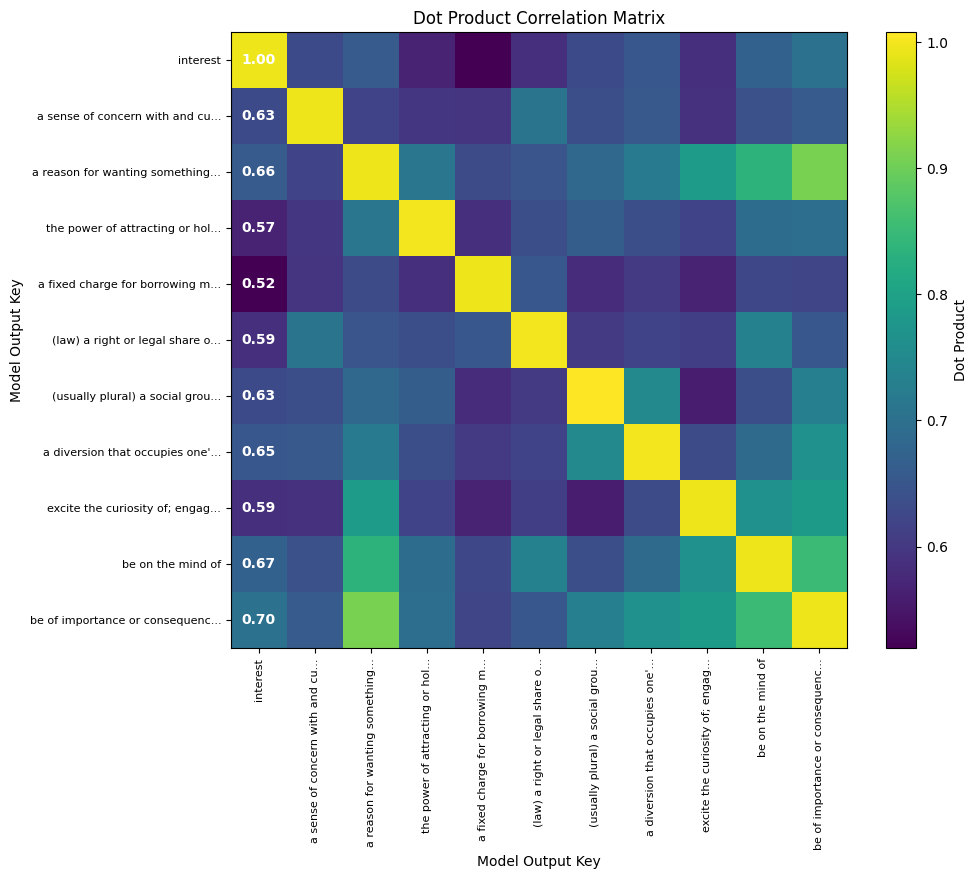

In [30]:
dots = compute_dot_product_matrix(sub_grp, jax_store_tmp, 15, 4)
plot_correlation_matrix(dots, sub_grp)

In [32]:
def compute_layerwise_dot_product_matrix(df: pd.DataFrame, store_path: str, tok_idx: int):
    """
    Compute a matrix where each column represents a layer, and each row represents an item in the dataset.
    The values are the dot products between the embeddings at each layer and the 0th entry's embeddings at that layer.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'model_output_key'.
        store_path (str): Path to the directory containing stored JAX arrays.

    Returns:
        np.ndarray: Layer-wise dot product matrix of shape (num_samples, num_layers).
    """
    arrays = []
    for key in df["model_output_key"]:
        arr = load_jax_array(key, store_path)
        arr = jnp.asarray(arr, dtype=jnp.float32)  # Convert bfloat16 to float32
        arr = arr[:, tok_idx, :]
        # Normalize each layer in the array
        # norms = jnp.linalg.norm(arr, axis=-1, keepdims=True)
        # arr = arr / norms
        arrays.append(arr)

    # Convert to a single JAX tensor (shape: num_samples x num_layers x embedding_dim)
    stacked_arrays = jnp.stack(arrays)  

    # Extract the 0th entry's embeddings as reference (shape: num_layers x embedding_dim)
    ref_embedding = stacked_arrays[0]  # Shape: (num_layers, embedding_dim)

    # print(ref_embedding.shape)
    # print(stacked_arrays.shape)

    # Compute dot products with each entry at each layer
    dot_matrix = jnp.einsum("wle,le->wl", stacked_arrays, ref_embedding)  # (num_samples, num_layers)

    # print(dot_matrix.shape)

    return np.array(dot_matrix, dtype=np.float32)  # Convert to NumPy for easier plotting

def compute_layerwise_delta_dot_product_matrix(df: pd.DataFrame, store_path: str, tok_idx: int, how = "rolling"):
    """
    Compute a matrix where each column represents a layer, and each row represents an item in the dataset.
    The values are the dot products between the embeddings at each layer and the 0th entry's embeddings at that layer.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'model_output_key'.
        store_path (str): Path to the directory containing stored JAX arrays.

    Returns:
        np.ndarray: Layer-wise dot product matrix of shape (num_samples, num_layers).
    """
    arrays = []
    for key in df["model_output_key"]:
        arr = load_jax_array(key, store_path) # (layers, toks, embedding)
        arr = jnp.asarray(arr, dtype=jnp.float32)  # Convert bfloat16 to float32
        arr = arr[:, tok_idx, :] # (lauers, embedding)
        # Normalize each layer in the array
        # norms = jnp.linalg.norm(arr, axis=-1, keepdims=True)
        # arr = arr / norms
        if how == "rolling":
            arr = arr[1:,:] - arr[:-1,:]
        elif how == "from_start":
            arr = arr[1:,:] - arr[0,:]
        else: 
            raise Exception("unexpected how")
        # norms2 = jnp.linalg.norm(arr, axis=-1, keepdims=True)
        # arr = arr / norms2
        arrays.append(arr)

    # Convert to a single JAX tensor (shape: num_samples x num_layers x embedding_dim)
    stacked_arrays = jnp.stack(arrays)  

    # Extract the 0th entry's embeddings as reference (shape: num_layers x embedding_dim)
    ref_embedding = stacked_arrays[0]  # Shape: (num_layers, embedding_dim)


    # Compute dot products with each entry at each layer
    dot_matrix = jnp.einsum("wle,le->wl", stacked_arrays, ref_embedding)  # (num_samples, num_layers)


    return np.array(dot_matrix, dtype=np.float32)  # Convert to NumPy for easier plotting


def plot_layerwise_correlation_matrix(matrix: np.ndarray, df: pd.DataFrame):
    """
    Plot a heatmap where each column represents a layer and each row represents an item in the dataset.

    Parameters:
        matrix (np.ndarray): The computed layer-wise dot product matrix.
        df (pd.DataFrame): DataFrame used to generate appropriate labels.
    """
    labels = get_labels(df)  # Generate labels (truncated definitions or words)

    plt.figure(figsize=(12, 6))
    plt.imshow(matrix, cmap="coolwarm", interpolation="nearest", aspect="auto")
    plt.colorbar(label="Dot Product with 0th Entry")
    
    true_def = sub_grp.iloc[0]["definition"]
    possibilities = str.split(sub_grp.iloc[0]["definitions"], '|')

    true_index = possibilities.index(true_def) + 1 # +1 offset sice we include the word 

    for col in range(matrix.shape[1]):
        true_value = matrix[true_index, col]
        plt.text(col, true_index, f"{true_value:.2f}", ha='center', va='center', color="blue", fontsize=9, fontweight="bold")
       
    
    for col in range(matrix.shape[1]):  # Iterate over layers
            sorted_indices = np.argsort(matrix[:, col])  # Sort by value
            if len(sorted_indices) > 1:
                second_highest_idx = sorted_indices[-2]  # Get second-highest value index
                second_highest_val = matrix[second_highest_idx, col]  # Get value

                # Determine text color (white on dark, black on light)
                text_color = "green" if second_highest_idx == true_index else "red"

                plt.text(col, second_highest_idx, f"{second_highest_val:.2f}", ha='center', va='center', 
                        color=text_color, fontsize=9, fontweight="bold")
                
   
 
    # Set axis labels
    plt.xticks(ticks=range(matrix.shape[1]), labels=[f"Layer {i}" for i in range(matrix.shape[1])], rotation=45, fontsize=8)
    plt.yticks(ticks=range(len(labels)), labels=labels, fontsize=8)

    plt.title("Layerwise Evolution of Dot Product Similarity")
    plt.xlabel("Model Layers")
    plt.ylabel("Definitions / Words")
    plt.show()

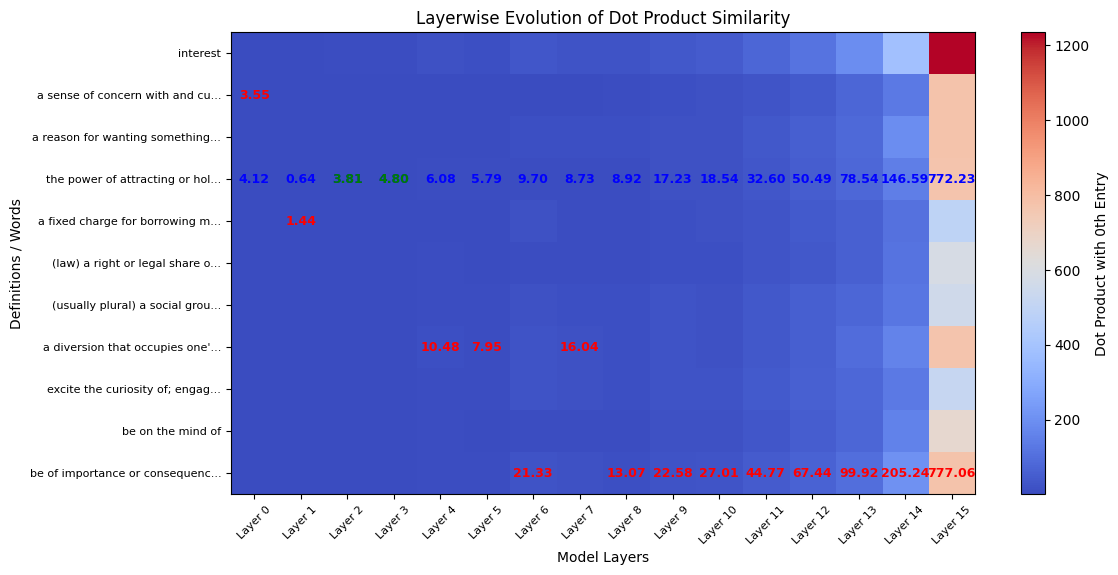

In [33]:
dot_matrix_layers = compute_layerwise_dot_product_matrix(sub_grp, jax_store_tmp, 6)
plot_layerwise_correlation_matrix(dot_matrix_layers, sub_grp)

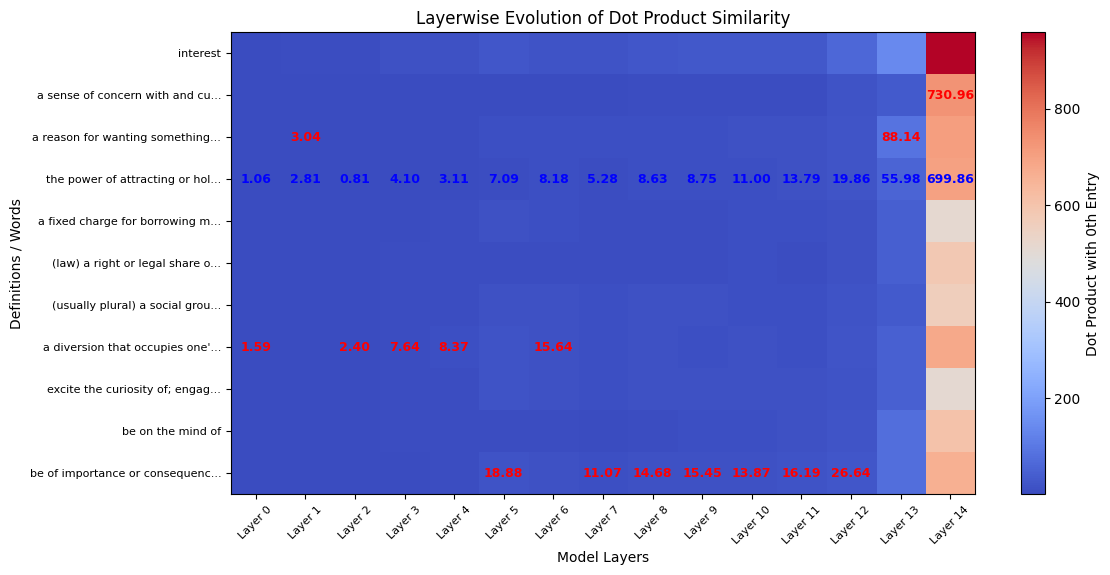

In [34]:
dot_matrix_layers = compute_layerwise_delta_dot_product_matrix(sub_grp, jax_store_tmp, 6, how="rolling")
plot_layerwise_correlation_matrix(dot_matrix_layers, sub_grp)

In [35]:
" ".join(str.split(sub_grp.iloc[0]["sentence"], '|'))

'A site which overlooks a harbor or river may offer interest in the activities of boating traffic .'

In [36]:
true_def = sub_grp.iloc[0]["definition"]
true_def

possibilities = str.split(sub_grp.iloc[0]["definitions"], '|')

possibilities.index(true_def)

2

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def compute_layerwise_ranking_scores(dot_matrix_layers_list, true_indices, how = "median"):
    """
    Compute ranking scores for each layer, normalized for number of options.
    
    Parameters:
        dot_matrix_layers_list (list of np.ndarray): List of (num_samples, num_layers) dot-product matrices.
        true_indices (list of int): List of true indices for each sample
            (1-based index, so we subtract 1 for actual row lookups).
        
    Returns:
        (np.ndarray, np.ndarray):
            mean_ranking_scores: shape (num_layers,)
            p25_ranking_scores: shape (num_layers,), the 25th percentile for each layer.
    """
    num_layers = dot_matrix_layers_list[0].shape[1]  # number of layers (columns)
    all_scores = []  # will collect per-sample normalized ranking scores for each layer

    for dot_matrix, row_idx in zip(dot_matrix_layers_list, true_indices):
        # Skip if index is invalid
        
        # Number of options
        num_options = dot_matrix.shape[0]
        if num_options == 1:
            continue # only the word and one definitions
        
        # Rank each column (layer) highest first
        # 1) argsort(-values) yields descending-order indices
        # 2) another argsort(...) on that result yields rank numbers
        rankings = np.argsort(np.argsort(-dot_matrix, axis=0), axis=0)  # shape: (num_options, num_layers)
        # print(rankings)
        # The rank of the true option in each layer
        true_ranks = rankings[row_idx, :]  # shape: (num_layers,)
        
        # Convert ranks into [0..1] scale (1.0 = best, 0.0 = worst)
        # rank=0 => best => normalized=1.0
        # rank=num_options-1 => worst => normalized=0.0
        normalized_ranks = 1 - (true_ranks / (num_options - 1))
        
        all_scores.append(normalized_ranks)

    if not all_scores:
        # If we have no valid samples, return None
        return None, None
    
    
    all_scores = np.vstack(all_scores)  # shape: (num_valid_samples, num_layers)
    
    # Mean ranking score for each layer
    if how == "median":
        ranking_scores = np.median(all_scores, axis=0)  # shape: (num_layers,)
    elif how == "mean":
        ranking_scores = np.mean(all_scores, axis=0)
    # 25th percentile for each layer
    p25_ranking_scores = np.percentile(all_scores, 25, axis=0)  # shape: (num_layers,)

    return ranking_scores, p25_ranking_scores


def plot_layerwise_prediction_quality_with_p25(ranking_scores, p25_ranking_scores):
    """
    Plot the mean ranking score per layer with the 25th percentile as the lower error bar.

    Parameters:
        mean_ranking_scores (np.ndarray): shape (num_layers,)
        p25_ranking_scores (np.ndarray): shape (num_layers,)
    """
    if ranking_scores is None or p25_ranking_scores is None:
        print("No valid scores to plot.")
        return

    layers = np.arange(len(ranking_scores))
    
    # Error bars: from p25 up to mean, so lower error = mean - p25, upper error = 0
    yerr_lower = ranking_scores - p25_ranking_scores
    yerr_upper = np.zeros_like(yerr_lower)
    
    # Combine into shape (2, num_layers) -> [ [lower_errors...], [upper_errors...] ]
    yerr = np.vstack([yerr_lower, yerr_upper])
    
    plt.figure(figsize=(10, 5))
    plt.errorbar(
        layers,
        ranking_scores,
        yerr=yerr,
        fmt='-o',
        capsize=3
    )
    plt.xlabel("Layer")
    plt.ylabel("Prediction Score\n(With 25th Percentile Error Bar)")
    plt.title("Layerwise Prediction Quality (Higher is Better)")
    plt.xticks(layers, labels=[f"Layer {i}" for i in layers], rotation=45)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()




In [38]:
dot_matrix_layers_list = []
dot_matrix_rolling_list = []
dot_matrix_from_start_list = []
true_indices = []

g = df.groupby("sentence")

for grp_id in tqdm(list(g.groups)):

    grp = g.get_group(grp_id)

    sub_g = grp.groupby("word")

    for sub_grp_id in list(sub_g.groups):

        sub_grp = sub_g.get_group(sub_grp_id)
        dot_matrix_layers = compute_layerwise_dot_product_matrix(sub_grp, jax_store_tmp, 4)
        dot_matrix_layers_rolling = compute_layerwise_delta_dot_product_matrix(sub_grp, jax_store_tmp, 4, how = "rolling")
        dot_matrix_layers_from_start = compute_layerwise_delta_dot_product_matrix(sub_grp, jax_store_tmp, 4, how = "from_start")
    

        true_def = sub_grp.iloc[0]["definition"]
        possibilities = str.split(sub_grp.iloc[0]["definitions"], '|')

        true_index = possibilities.index(true_def) # +1 offset sice we include the word 

        dot_matrix_layers_list.append(dot_matrix_layers[1:,:])
        dot_matrix_rolling_list.append(dot_matrix_layers_from_start[1:,:])
        dot_matrix_from_start_list.append(dot_matrix_layers_from_start[1:,:])
        true_indices.append(true_index)
        # plot_layerwise_correlation_matrix(dot_matrix_layers, sub_grp)

  0%|                                                                                            | 0/99 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:57<00:00,  1.72it/s]


### Raw dot product

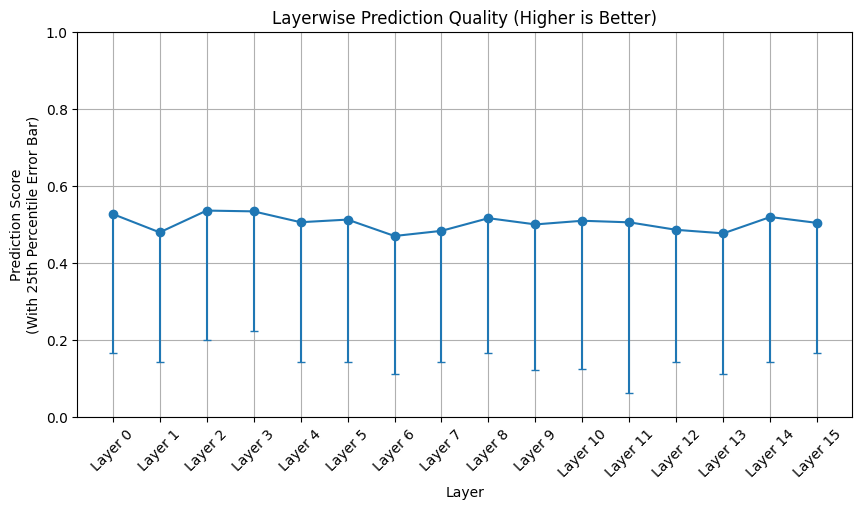

In [39]:
ranking_scores, std_ranking_scores = compute_layerwise_ranking_scores(dot_matrix_layers_list, true_indices, how = "mean")
plot_layerwise_prediction_quality_with_p25(ranking_scores, std_ranking_scores)

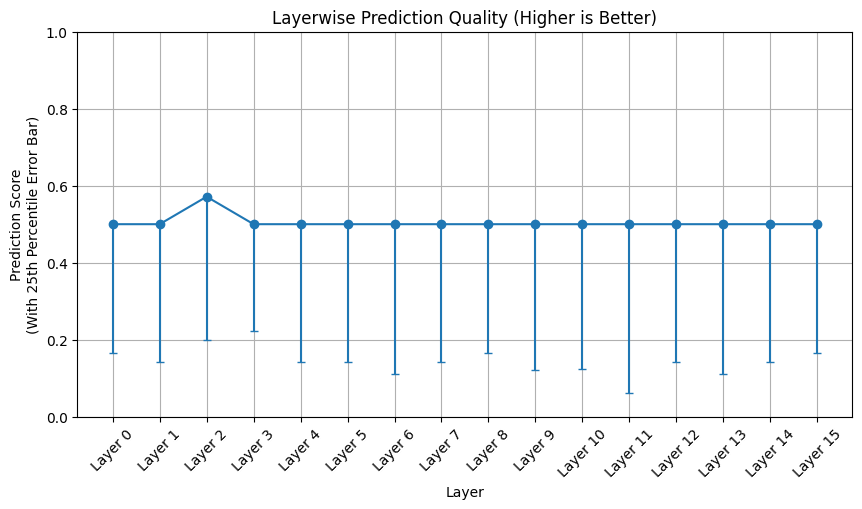

In [40]:
median_ranking_scores, std_ranking_scores = compute_layerwise_ranking_scores(dot_matrix_layers_list, true_indices, how = "median")
plot_layerwise_prediction_quality_with_p25(median_ranking_scores, std_ranking_scores)

### Rolling delta dot product

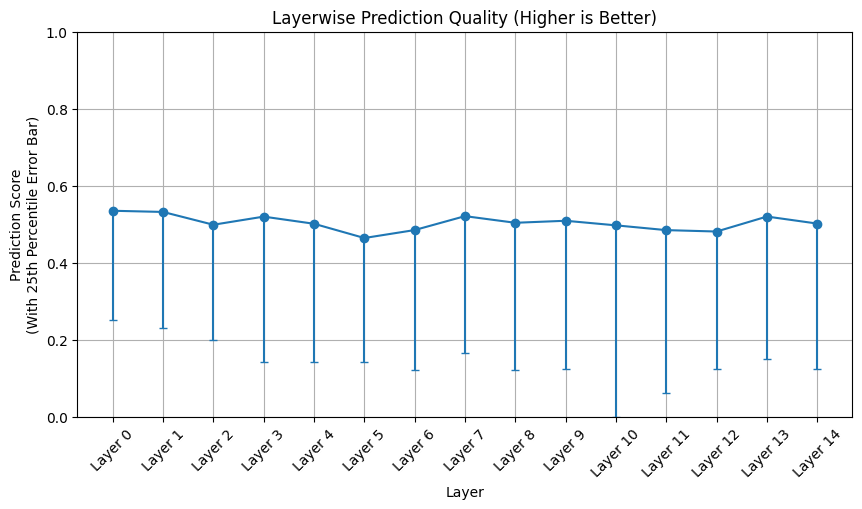

In [41]:
ranking_scores, std_ranking_scores = compute_layerwise_ranking_scores(dot_matrix_rolling_list, true_indices, how = "mean")
plot_layerwise_prediction_quality_with_p25(ranking_scores, std_ranking_scores)

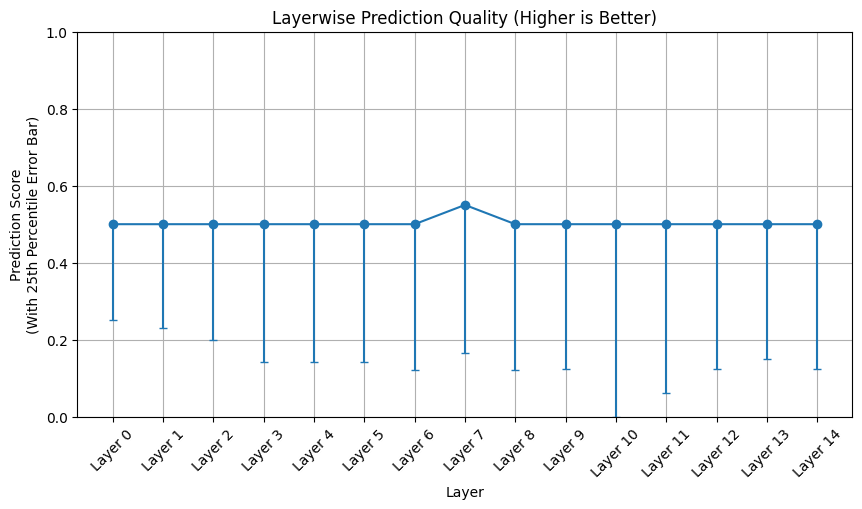

In [42]:
ranking_scores, std_ranking_scores = compute_layerwise_ranking_scores(dot_matrix_rolling_list, true_indices, how = "median")
plot_layerwise_prediction_quality_with_p25(ranking_scores, std_ranking_scores)

### delta from first layer dot product

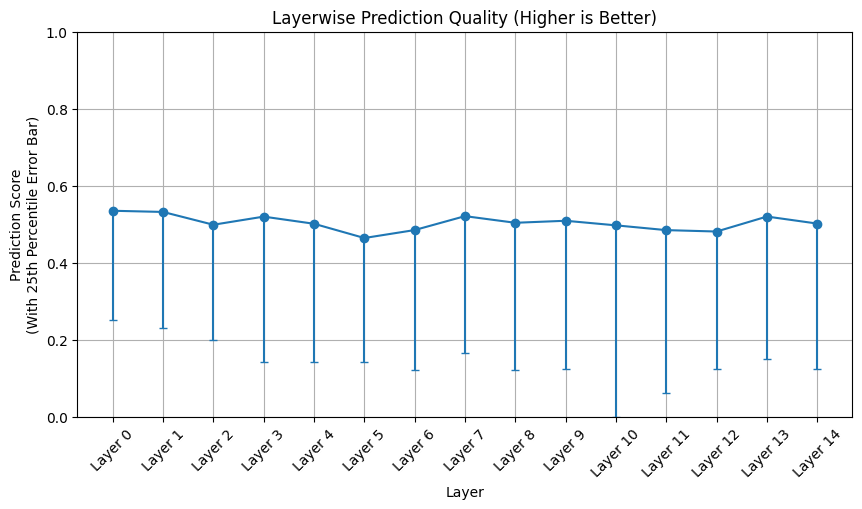

In [43]:
ranking_scores, std_ranking_scores = compute_layerwise_ranking_scores(dot_matrix_from_start_list, true_indices, how = "mean")
plot_layerwise_prediction_quality_with_p25(ranking_scores, std_ranking_scores)

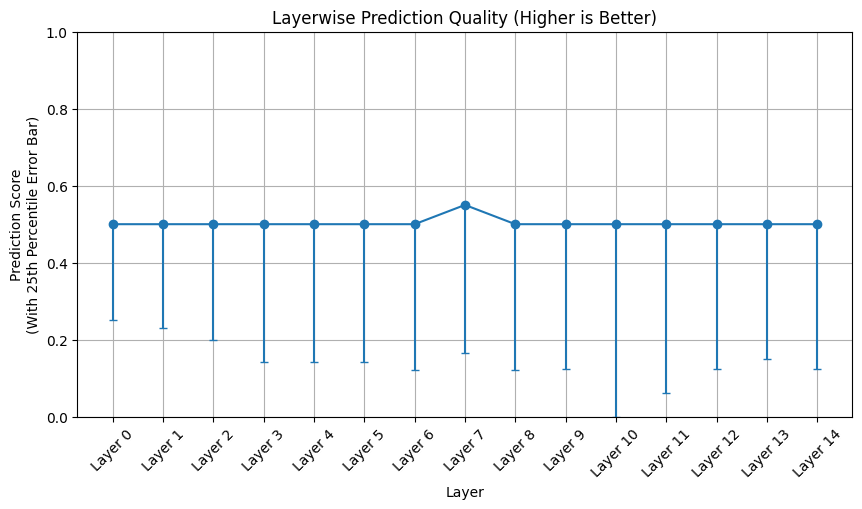

In [44]:
ranking_scores, std_ranking_scores = compute_layerwise_ranking_scores(dot_matrix_from_start_list, true_indices, how = "median")
plot_layerwise_prediction_quality_with_p25(ranking_scores, std_ranking_scores)

We see some signal, however further investigation is clearly required.

That the median outperforms the mean is particulary interesting.

## Why are all the dot products positive?

Here we notice something interesting, that we never observe a negative dot product, even when considering the layer on layer deltas, or the delta from the initial.

This suggests that the rough positions at the layer are centred at different points, we should investigate how the **centred** values are different

Note - we look at the absolute value of the delta now, so see just if the linear subspaces overlap

In [45]:
def compute_layerwise_centred_dot_product_matrix(df: pd.DataFrame, store_path: str, tok_idx: int):
    """
    Compute a matrix where each column represents a layer, and each row represents an item in the dataset.
    The values are the dot products between the embeddings at each layer and the 0th entry's embeddings at that layer.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'model_output_key'.
        store_path (str): Path to the directory containing stored JAX arrays.

    Returns:
        np.ndarray: Layer-wise dot product matrix of shape (num_samples, num_layers).
    """
    arrays = []
    for key in df["model_output_key"]:
        arr = load_jax_array(key, store_path)
        arr = jnp.asarray(arr, dtype=jnp.float32)  # Convert bfloat16 to float32
        arr = arr[:, tok_idx, :]
        # Normalize each layer in the array
        # norms = jnp.linalg.norm(arr, axis=-1, keepdims=True)
        # arr = arr / norms
        arrays.append(arr)

    # Convert to a single JAX tensor (shape: num_samples x num_layers x embedding_dim)
    stacked_arrays = jnp.stack(arrays)

    centres = stacked_arrays.mean(axis=0, keepdims=True) 

    stacked_arrays = stacked_arrays - centres  

    # Extract the 0th entry's embeddings as reference (shape: num_layers x embedding_dim)
    ref_embedding = stacked_arrays[0]  # Shape: (num_layers, embedding_dim)

    # print(ref_embedding.shape)
    # print(stacked_arrays.shape)

    # Compute dot products with each entry at each layer
    dot_matrix = jnp.einsum("wle,le->wl", stacked_arrays, ref_embedding)  # (num_samples, num_layers)

    dot_matrix = jnp.abs(dot_matrix)    

    # print(dot_matrix.shape)

    return np.array(dot_matrix, dtype=np.float32)  # Convert to NumPy for easier plotting


In [46]:

def compute_layerwise_centred_delta_dot_product_matrix(df: pd.DataFrame, store_path: str, tok_idx: int, how = "rolling"):
    """
    Compute a matrix where each column represents a layer, and each row represents an item in the dataset.
    The values are the dot products between the embeddings at each layer and the 0th entry's embeddings at that layer.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'model_output_key'.
        store_path (str): Path to the directory containing stored JAX arrays.

    Returns:
        np.ndarray: Layer-wise dot product matrix of shape (num_samples, num_layers).
    """
    arrays = []
    for key in df["model_output_key"]:
        arr = load_jax_array(key, store_path) # (layers, toks, embedding)
        arr = jnp.asarray(arr, dtype=jnp.float32)  # Convert bfloat16 to float32
        arr = arr[:, tok_idx, :] # (lauers, embedding)
        # Normalize each layer in the array
        # norms = jnp.linalg.norm(arr, axis=-1, keepdims=True)
        # arr = arr / norms
        if how == "rolling":
            arr = arr[1:,:] - arr[:-1,:]
        elif how == "from_start":
            arr = arr[1:,:] - arr[0,:]
        else: 
            raise Exception("unexpected how")
        # norms2 = jnp.linalg.norm(arr, axis=-1, keepdims=True)
        # arr = arr / norms2
        arrays.append(arr)

    # Convert to a single JAX tensor (shape: num_samples x num_layers x embedding_dim)
    stacked_arrays = jnp.stack(arrays)  
    
    centres = stacked_arrays.mean(axis=0, keepdims=True) 

    stacked_arrays = stacked_arrays - centres  


    # Extract the 0th entry's embeddings as reference (shape: num_layers x embedding_dim)
    ref_embedding = stacked_arrays[0]  # Shape: (num_layers, embedding_dim)


    # Compute dot products with each entry at each layer
    dot_matrix = jnp.einsum("wle,le->wl", stacked_arrays, ref_embedding)  # (num_samples, num_layers)

    dot_matrix = jnp.abs(dot_matrix)

    return np.array(dot_matrix, dtype=np.float32)  # Convert to NumPy for easier plotting



In [47]:
dot_matrix_layers_list_c = []
dot_matrix_rolling_list_c = []
dot_matrix_from_start_list_c = []
true_indices = []

g = df.groupby("sentence")

for grp_id in tqdm(list(g.groups)):

    grp = g.get_group(grp_id)

    sub_g = grp.groupby("word")

    for sub_grp_id in list(sub_g.groups):

        sub_grp = sub_g.get_group(sub_grp_id)
        dot_matrix_layers = compute_layerwise_centred_dot_product_matrix(sub_grp, jax_store_tmp, 4)
        dot_matrix_layers_rolling = compute_layerwise_centred_delta_dot_product_matrix(sub_grp, jax_store_tmp, 4, how = "rolling")
        dot_matrix_layers_from_start = compute_layerwise_centred_delta_dot_product_matrix(sub_grp, jax_store_tmp, 4, how = "from_start")
    
        true_def = sub_grp.iloc[0]["definition"]
        possibilities = str.split(sub_grp.iloc[0]["definitions"], '|')

        true_index = possibilities.index(true_def) # +1 offset sice we include the word 

        dot_matrix_layers_list_c.append(dot_matrix_layers[1:,:])
        dot_matrix_rolling_list_c.append(dot_matrix_layers_from_start[1:,:])
        dot_matrix_from_start_list_c.append(dot_matrix_layers_from_start[1:,:])
        true_indices.append(true_index)
# 

  0%|                                                                                            | 0/99 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:55<00:00,  1.79it/s]


### Raw dot product

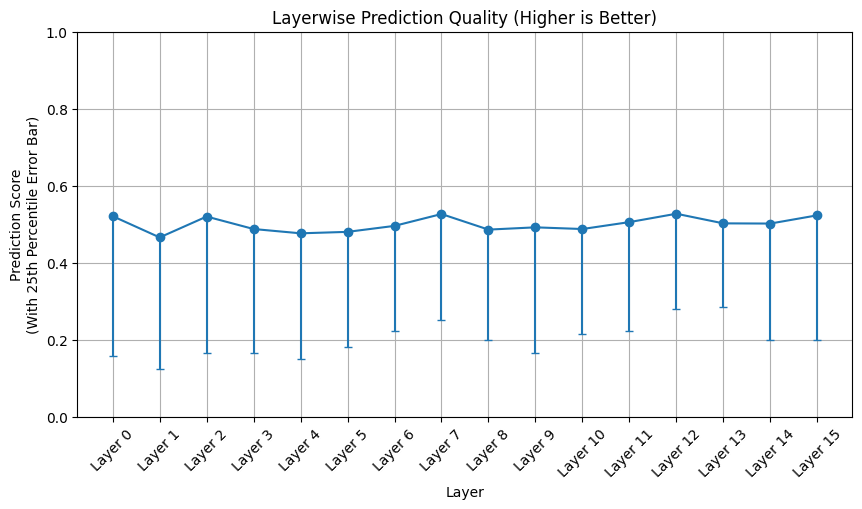

In [48]:
ranking_scores, std_ranking_scores = compute_layerwise_ranking_scores(dot_matrix_layers_list_c, true_indices, how = "mean")
plot_layerwise_prediction_quality_with_p25(ranking_scores, std_ranking_scores)

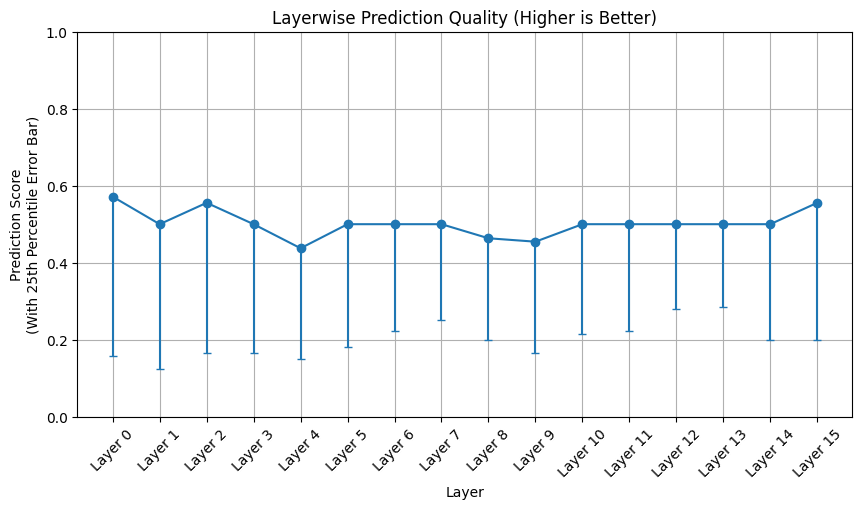

In [49]:
ranking_scores, std_ranking_scores = compute_layerwise_ranking_scores(dot_matrix_layers_list_c, true_indices, how = "median")
plot_layerwise_prediction_quality_with_p25(ranking_scores, std_ranking_scores)

### Rolling delta dot product

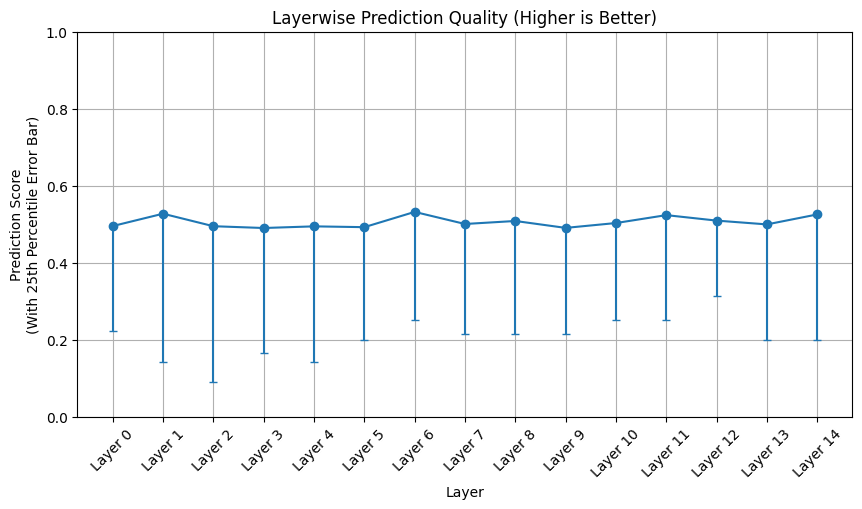

In [50]:
ranking_scores, std_ranking_scores = compute_layerwise_ranking_scores(dot_matrix_rolling_list_c, true_indices, how = "mean")
plot_layerwise_prediction_quality_with_p25(ranking_scores, std_ranking_scores)

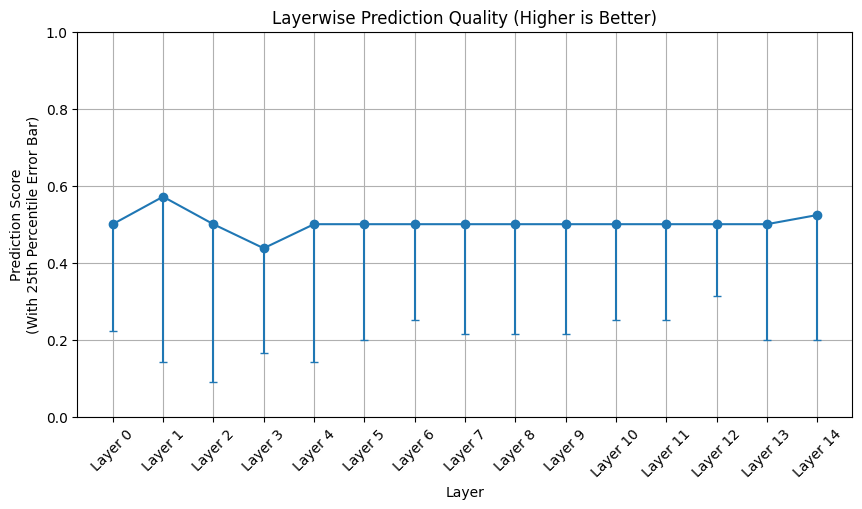

In [51]:
ranking_scores, std_ranking_scores = compute_layerwise_ranking_scores(dot_matrix_rolling_list_c, true_indices, how = "median")
plot_layerwise_prediction_quality_with_p25(ranking_scores, std_ranking_scores)

### Delta from first layer

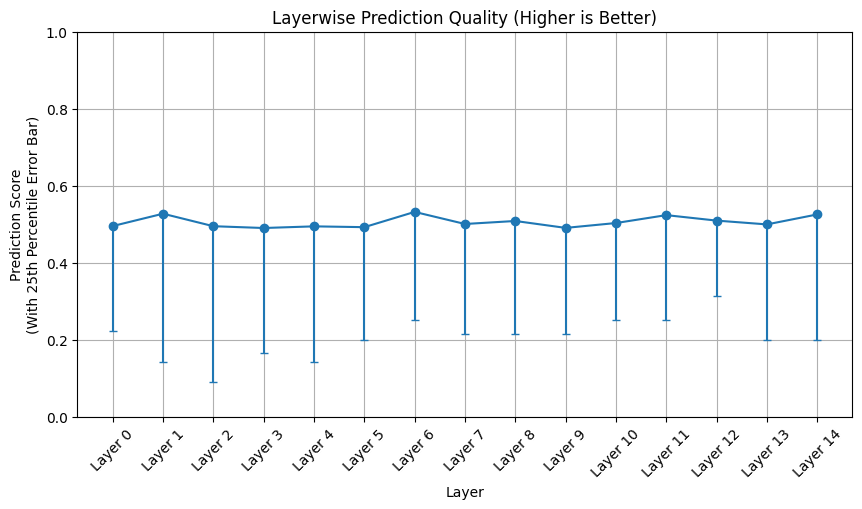

In [52]:
ranking_scores, std_ranking_scores = compute_layerwise_ranking_scores(dot_matrix_from_start_list_c, true_indices, how = "mean")
plot_layerwise_prediction_quality_with_p25(ranking_scores, std_ranking_scores)

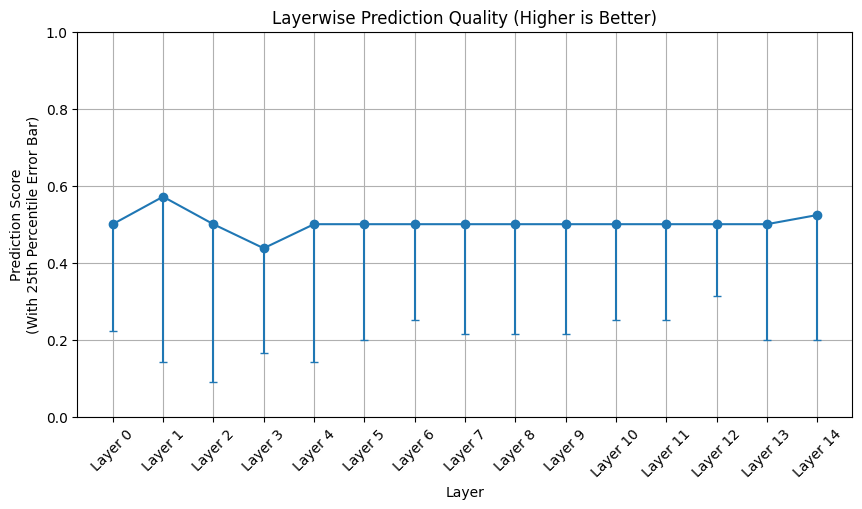

In [53]:
ranking_scores, std_ranking_scores = compute_layerwise_ranking_scores(dot_matrix_from_start_list_c, true_indices, how = "median")
plot_layerwise_prediction_quality_with_p25(ranking_scores, std_ranking_scores)

## Observations

We see something interesting now, when un-centred, the predictivity decreases through the layers, whereas when centred and |.|'d it increases

Removing normalisation also saw an increase in predictivity.

The best uncentred layer is layer 2 - using raw dot product - no normalisation

The best centred layer is layer 11 - again using the raw dot product - no normalisation - using absolute values


What happens if we use a mixture of experts here

In [54]:
dot_matrix_layers_list[0].shape

(2, 16)

In [55]:
dot_matrix_layers_list_c[0].shape

(2, 16)

In [ ]:
import numpy as np

def compute_mixture_ranking_scores(
    dot_layers_mat_list1,
    dot_layers_mat_list2,
    layer1,
    layer2,
    true_indices,
    how="median",
    how_mix="avg"
):
    """
    Compute ranking scores via a mixture of two experts (layers).
    We take dot_layers_mat_list1[.., layer1] and dot_layers_mat_list2[.., layer2].
    For each sample:
      1) Rank each column (layer) separately (descending = better).
      2) Average those two ranks across each row to get a final "mixture" rank.
      3) Compute the normalized rank for the true answer.
    Finally return the (median or mean) of those scores across samples
    and the 25th percentile score.

    Parameters
    ----------
    dot_layers_mat_list1 : list of np.ndarray
        Each element is an (N_i, L1) dot-product matrix for sample i.
        We will only use the column = layer1 from each.
    dot_layers_mat_list2 : list of np.ndarray
        Each element is an (N_i, L2) dot-product matrix for sample i.
        We will only use the column = layer2 from each.
    layer1 : int
        The index of the layer (column) in dot_layers_mat_list1 to use.
    layer2 : int
        The index of the layer (column) in dot_layers_mat_list2 to use.
    true_indices : list of int
        List of true row indices (1-based) for each sample.
        We subtract 1 for actual zero-based lookup.
    how : str, optional
        "median" or "mean", determines how we aggregate final scores across samples.

    Returns
    -------
    ranking_score : float
        The median or mean (depending on `how`) of the per-sample normalized ranks.
    p25_ranking_score : float
        The 25th percentile of the per-sample normalized ranks.
    """
    all_scores = []

    for dot_mat1, dot_mat2, row_idx in zip(dot_layers_mat_list1, dot_layers_mat_list2, true_indices):

        # Number of options
        num_options = dot_mat1.shape[0]
        if num_options == 1:
            continue # only the word and one definitions

        # Extract just the single "expert" column from each dot-matrix
        # shape: (num_options,) for each
        col1 = dot_mat1[:, layer1]
        col2 = dot_mat2[:, layer2]

        num_options = len(col1)  # Should match len(col2) as well

        # -- Rank each expert column individually --
        # rank=0 => best (descending order), rank=num_options-1 => worst
        # We do argsort on negative values to get descending order
        ranks1 = np.argsort(np.argsort(-col1))
        ranks2 = np.argsort(np.argsort(-col2))

        # -- Average the two ranks to get a final "mixture" rank for each row
        # The best row has the smallest average rank
        # 1) Compute the average rank for each row
        if how_mix == "avg":
            avg_ranks = (ranks1 + ranks2) / 2.0
        elif how_mix == "min":
            avg_ranks = np.minimum(ranks1, ranks2)
        elif how_mix == "max":
            avg_ranks = np.maximum(ranks1, ranks2)
        elif how_mix == "har":
            avg_ranks = 1.0 / (((1.0/ranks1) + (1.0/ranks2)) / 2.0)

        # 2) Re-rank by ascending avg_ranks -> final_ranks in [0..num_options-1]
        final_ranks = np.argsort(np.argsort(avg_ranks))  # shape: (num_options,)

        # 3) Extract the rank of the true row
        true_rank = final_ranks[row_idx]

        # 4) Convert to [0..1] (1 => best, 0 => worst)
        normalized_rank = 1.0 - (true_rank / (num_options - 1))

        all_scores.append(normalized_rank)

    if not all_scores:
        # If no valid samples, return None for both
        return None, None

    all_scores = np.array(all_scores)

    if how == "median":
        ranking_score = np.median(all_scores)
    elif how == "mean":
        ranking_score = np.mean(all_scores)
    else:
        raise ValueError("Invalid 'how' specified; use 'median' or 'mean'.")

    p25_ranking_score = np.percentile(all_scores, 25)

    return ranking_score, p25_ranking_score


In [57]:
compute_mixture_ranking_scores(
    dot_matrix_layers_list,
    dot_matrix_layers_list_c,
    2,
    12,
    true_indices,
    how="median")

(0.5833333333333333, 0.2142857142857143)

In [58]:
compute_mixture_ranking_scores(
    dot_matrix_layers_list,
    dot_matrix_layers_list_c,
    2,
    12,
    true_indices,
    how="mean")

(0.5372376751421608, 0.2142857142857143)

Not bad! On average the correct answer is in the top 1/3 of results, with over half being in the top 20%

In [59]:
dot_matrix_layers_list_c[0].shape

(2, 16)

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mixture_heatmap(dot_matrix_layers_list, 
                         dot_matrix_layers_list_c, 
                         true_indices,
                         max_layer=16,
                         how = "mean",
                         how_mix = "avg"):
    # We'll store the mean ranking_score in a 2D array: [layer1, layer2]
    score_matrix = np.zeros((max_layer, max_layer), dtype=float)

    for layer1, layer2 in tqdm([(i, j) for i in range(max_layer) for j in range(max_layer)], desc="Computing scores"):
            ranking_score, _ = compute_mixture_ranking_scores(
                dot_matrix_layers_list, 
                dot_matrix_layers_list_c,
                layer1,
                layer2,
                true_indices,
                how=how,
                how_mix=how_mix
            )
            # If ranking_score is None (e.g. no valid samples), store NaN
            score_matrix[layer1, layer2] = ranking_score if ranking_score is not None else np.nan

    # Plot as a heatmap
    plt.imshow(score_matrix, origin='lower', aspect='auto')
    plt.colorbar(label=f"{how} Mixture Ranking Score")
    plt.ylabel("Layer Index (Uncentred Dot-Matrix List)")
    plt.xlabel("Layer Index (Centred Dot-Matrix List)")
    plt.title(f"Heatmap of Mixture ({how_mix}) Ranking Scores ({how})")

    flat_indices = np.argsort(score_matrix.flatten())[::-1]  # descending
    top_indices = [(idx // max_layer, idx % max_layer) for idx in flat_indices if not np.isnan(score_matrix.flatten()[idx])][:10]

    # Add text annotations for top 10 scores
    for i, j in top_indices:
        score_val = score_matrix[i, j]
        plt.text(j, i, f"{score_val:.2f}", ha='center', va='center', color='white', fontsize=8, weight='bold')

    plt.show()

Computing scores:   0%|                                                                         | 0/256 [00:00<?, ?it/s]

Computing scores: 100%|██████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 238.57it/s]


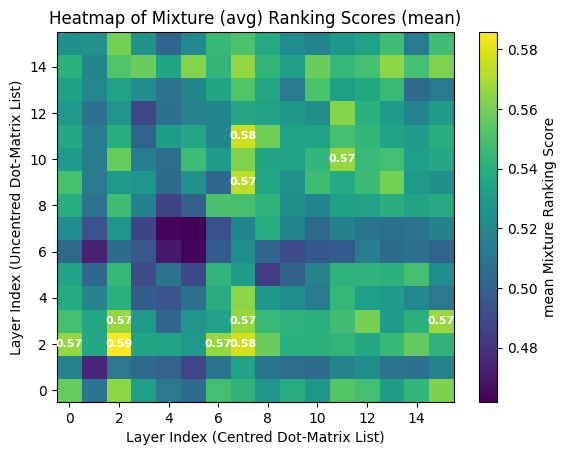

In [61]:
plot_mixture_heatmap(dot_matrix_layers_list,
                     dot_matrix_layers_list_c,
                     true_indices,
                     max_layer=16,
                     how="mean")

Computing scores:   3%|█▊                                                               | 7/256 [00:00<00:03, 66.23it/s]

Computing scores: 100%|██████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 177.87it/s]


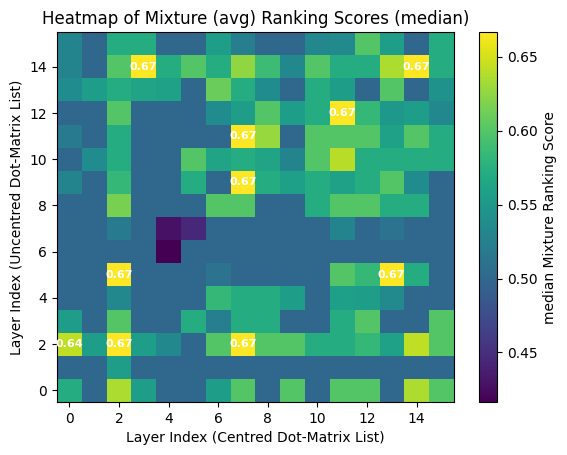

In [62]:
plot_mixture_heatmap(dot_matrix_layers_list,
                     dot_matrix_layers_list_c,
                     true_indices,
                     max_layer=16,
                     how="median")

Computing scores: 100%|██████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 253.38it/s]


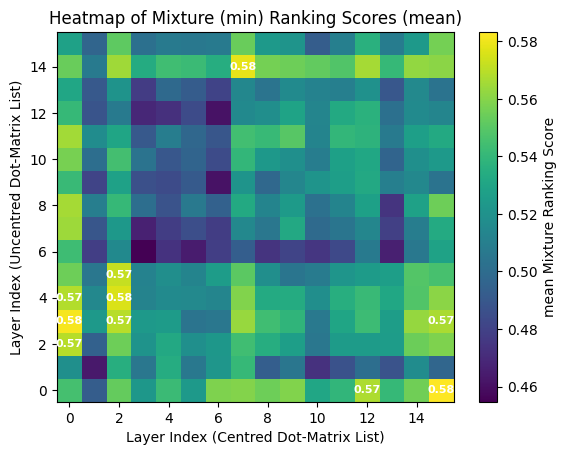

In [63]:
plot_mixture_heatmap(dot_matrix_layers_list,
                     dot_matrix_layers_list_c,
                     true_indices,
                     max_layer=16,
                     how="mean",
                     how_mix='min')

Computing scores:   0%|                                                                         | 0/256 [00:00<?, ?it/s]

Computing scores: 100%|██████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 267.26it/s]


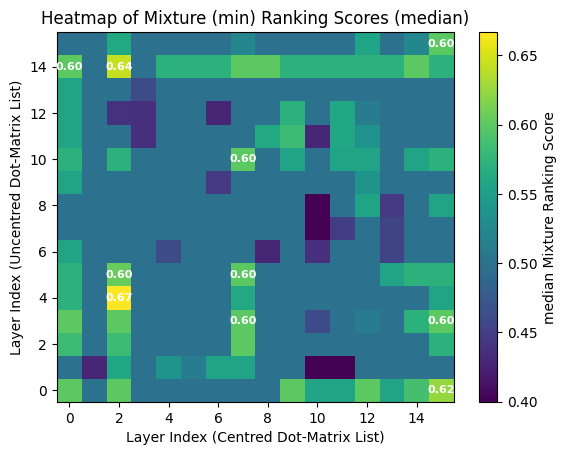

In [64]:
plot_mixture_heatmap(dot_matrix_layers_list,
                     dot_matrix_layers_list_c,
                     true_indices,
                     max_layer=16,
                     how="median",
                     how_mix='min')

Computing scores:   3%|██                                                               | 8/256 [00:00<00:03, 73.76it/s]

Computing scores: 100%|██████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 137.50it/s]


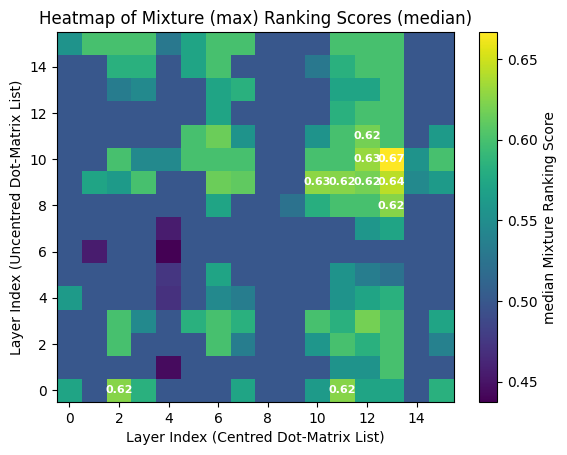

In [65]:
plot_mixture_heatmap(dot_matrix_layers_list,
                     dot_matrix_layers_list_c,
                     true_indices,
                     max_layer=16,
                     how="median",
                     how_mix='max')

Computing scores: 100%|██████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 155.92it/s]


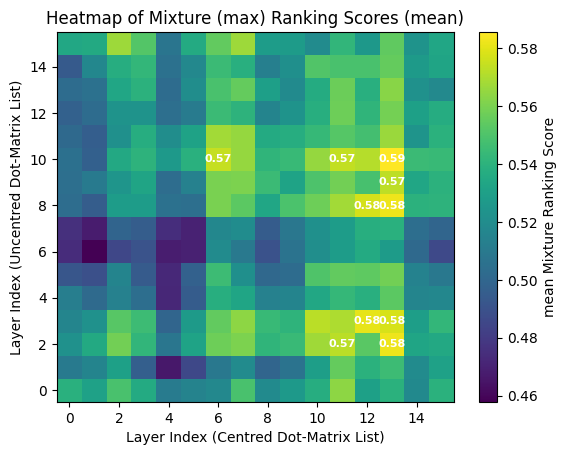

In [66]:
plot_mixture_heatmap(dot_matrix_layers_list,
                     dot_matrix_layers_list_c,
                     true_indices,
                     max_layer=16,
                     how="mean",
                     how_mix='max')

Computing scores:   0%|                                                                         | 0/256 [00:00<?, ?it/s]/tmp/ipykernel_11554/3191052154.py:79: RuntimeWarning: divide by zero encountered in divide
  avg_ranks = 1.0 / (((1.0/ranks1) + (1.0/ranks2)) / 2.0)
Computing scores: 100%|██████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 201.14it/s]


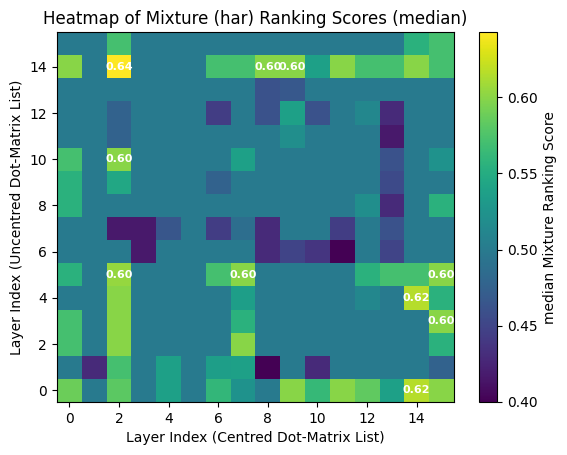

In [67]:
plot_mixture_heatmap(dot_matrix_layers_list,
                     dot_matrix_layers_list_c,
                     true_indices,
                     max_layer=16,
                     how="median",
                     how_mix='har')

Computing scores:   0%|                                                                         | 0/256 [00:00<?, ?it/s]/tmp/ipykernel_11554/3191052154.py:79: RuntimeWarning: divide by zero encountered in divide
  avg_ranks = 1.0 / (((1.0/ranks1) + (1.0/ranks2)) / 2.0)
Computing scores: 100%|██████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 227.48it/s]


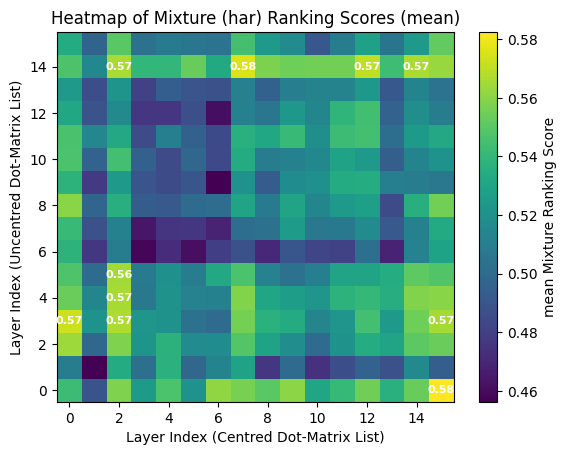

In [68]:
plot_mixture_heatmap(dot_matrix_layers_list,
                     dot_matrix_layers_list_c,
                     true_indices,
                     max_layer=16,
                     how="mean",
                     how_mix='har')

## Conclusions

We see that mean averaging the ranks, then reranking, yields decent performance, in layer (3,4), (3, 12) and (14, 10)  [(uncentred, centred)]

What happens if we mixture all these ranks?

In [76]:
import numpy as np

def compute_mixture_ranking_scores(
    dot_layers_mat_list1,
    dot_layers_mat_list2,
    layers1,
    layers2,
    true_indices,
    how="median",
):
    all_scores = []

    for dot_mat1, dot_mat2, row_idx in zip(dot_layers_mat_list1, dot_layers_mat_list2, true_indices):

        # Number of options
        num_options = dot_mat1.shape[0]
        if num_options == 1:
            continue # only the word and one definitions

        # Extract just the single "expert" column from each dot-matrix
        # shape: (num_options,) for each

        first = True

        for layer1, layer2 in zip(layers1, layers2):

            col1 = dot_mat1[:, layer1]
            col2 = dot_mat2[:, layer2]

            num_options = len(col1)  # Should match len(col2) as well

            # -- Rank each expert column individually --
            # rank=0 => best (descending order), rank=num_options-1 => worst
            # We do argsort on negative values to get descending order
            ranks1 = np.argsort(np.argsort(-col1))
            ranks2 = np.argsort(np.argsort(-col2))

            # -- Average the two ranks to get a final "mixture" rank for each row
            # The best row has the smallest average rank
            # 1) Compute the average rank for each row
            if first == True:
                combined = ranks1 + ranks2
                first = False   
            else:
                combined = combined + ranks1 + ranks2


        # 2) Re-rank by ascending avg_ranks -> final_ranks in [0..num_options-1]
        final_ranks = np.argsort(np.argsort(combined))  # shape: (num_options,)

        # 3) Extract the rank of the true row
        true_rank = final_ranks[row_idx]

        # 4) Convert to [0..1] (1 => best, 0 => worst)
        normalized_rank = 1.0 - (true_rank / (num_options - 1))

        all_scores.append(normalized_rank)

    if not all_scores:
        # If no valid samples, return None for both
        return None, None

    all_scores = np.array(all_scores)

    if how == "median":
        ranking_score = np.median(all_scores)
    elif how == "mean":
        ranking_score = np.mean(all_scores)
    else:
        raise ValueError("Invalid 'how' specified; use 'median' or 'mean'.")

    p25_ranking_score = np.percentile(all_scores, 25)

    return ranking_score, p25_ranking_score


In [81]:
compute_mixture_ranking_scores(
    dot_matrix_from_start_list,
    dot_matrix_from_start_list_c,
    14,
    2,
    true_indices,
    how="median")

[0 1]
[0 1]


[0 1 2]
[2 1 0]


[4 2 8 9 7 5 1 6 3 0]
[4 5 3 2 0 7 8 6 1 9]


[1 2 0]
[2 0 1]


[4 3 1 2 0]
[1 4 0 2 3]


[3 4 5 6 2 1 0]
[3 2 4 1 6 0 5]


[0 1]
[0 1]


[11 14 40  0 13  3 20 12 32  4 18 16 28  8 30 10  6 35 19  7 27 22 17 39
 36 33 41 26  2 37 34 29 25 23 24 38 21 31 15  5  1  9]
[23 18 12 28  1 13 24  7 17 27 16 40 37  6 34  2 30 29 25 32 22 26 21  4
  9  8 19 33  0 11 35 31 38 15  3  5 14 39 20 10 36 41]


[ 5  0  4  9 13  2  6 17 11 18 10  8 14  7 15 16  3 12 19  1]
[11  7 13 12 10 19 18  0 15  8 17  6 16  3  1  9 14  2  5  4]


[41  1 35 29 10  3 26 38  8  0  6 31 34 22 12 30 36  7 28 19 15 37  2 20
 43 27 33 11  9  5 42  4 39 16 17 18 32 13 25 23 21 40 24 14]
[29 38 25  9 26 28 34 18 14 23  2 35 10 31 17 36 22 20  0 40 39  6 33  5
 41 43  7 27 15 32 11  4 16  8 37 12 42 21  1  3 13 19 30 24]


[0 2 3 1]
[0 2 1 3]


[ 4 11 12  9  6  8  5 10  0  1  3  7  2]
[ 0  1  7  3  8  9  2  6  5 11 10 12  4]


[1 0 7 4 8 6 5 2 3]
[1 0 3 4 8 2 6 5 7]


[0 3 1 4 5 2]
[2 0 1 3 4

(0.5, 0.18181818181818177)

In [72]:
compute_mixture_ranking_scores(
    dot_matrix_from_start_list,
    dot_matrix_from_start_list_c,
    (7,7),
    (8,8),
    true_indices,
    how="mean")

(0.8552587361627882, 0.8)

That seems to perform worse

## Next steps

Now we have some theory as to what sort of predictor is best, we should create a script to output all the dot matrices that we are interested in, run our ranking score method.

Then we can see if these results hold up on unseed data. Also using the dot matrices as features, we can look into training an MLP to predict the top definition.